In [7]:
import cv2
import torch
import torch.utils.data
import numpy as np
import scipy.io as scio
import os
from scipy import stats, ndimage
from PIL import Image

from tqdm import tqdm
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline

import importlib

In [8]:
import models
from utils.handDetector import HandDetector
import utils

In [25]:
# importlib.reload(models.a2j)
importlib.reload(utils.display)

<module 'utils.display' from 'e:\\Projects\\LiveGestureUseDepthCamera\\utils\\display.py'>

In [32]:
# sr300 parm
fx = 475.065948
fy = 475.065857
ux = 315.944855
uy = 245.287079
max_depth = 500
depth_scale = 0.00012498664727900177 
hand_mean = -6.39239157
hand_std = 25.00686072

# a2j param

cropWidth = 176
cropHeight = 176
worldBoxSize = 160
depth_thres = 150



# init

# DATA

In [104]:
depth_img = np.asanyarray(np.load("./data/depth0.npy"),dtype=np.float32)*depth_scale*1000
depth_img[370:] = 0


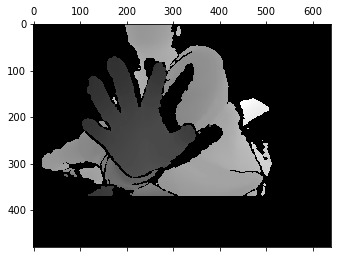

In [112]:
# depth_img2 = cv2.fastNlMeansDenoising(np.uint8(depth_img),h=3,templateWindowSize=3,searchWindowSize=3)
depth_img2 = cv2.medianBlur(depth_img,3)
plt.matshow(depth_img2, cmap=plt.cm.gray)
plt.show()

[219.4295 212.355  255.0921]
[[ 1.69302825  0.          0.         63.36854   ]
 [ 0.          1.69302792  0.         70.44301732]
 [ 0.          0.          1.          0.        ]
 [ 0.          0.          0.          1.        ]]


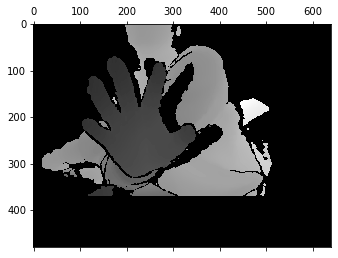

In [109]:
hand = HandDetector(depth_img,fx, fy,ux,uy,max_depth)
handCrop,com,mat = hand.detect(worldBoxSize=worldBoxSize)

print(com)
print(mat)
plt.matshow(depth_img, cmap=plt.cm.gray)
plt.show()

# Hand2017

In [85]:
keypointsNumber = 21
model_dir="./models/a2j/model/HANDS2017.pth"
hand_mean = -6.39239157
hand_std = 25.00686072
jointDetector = models.a2j.JointDetector(model_dir=model_dir, keypointsNumber=keypointsNumber,useCuda=True)

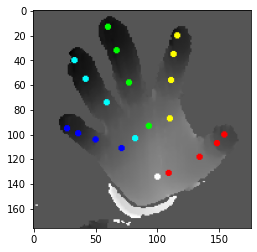

In [110]:
display_img = utils.display.matToImg(handCrop)
result = jointDetector.forward(utils.math.scaleImg(handCrop,hand_mean,hand_std))
result_ = jointDetector.convertHand2017ToMpOrder(result)
display_img = utils.display.drawResult(result_,display_img)
plt.imshow(display_img)

In [60]:
result_[:,2].max()

98.9922103881836

In [58]:
test_lefttop_pixel, test_rightbottom_pixel = hand.comToBounds(com,worldBoxSize/2,True)
mat = hand.getTransMat(test_lefttop_pixel, test_rightbottom_pixel)
print(mat)

[[ 1.6925599   0.          0.         63.46888288]
 [ 0.          1.69255957  0.         70.39727441]
 [ 0.          0.          1.          0.        ]
 [ 0.          0.          0.          1.        ]]


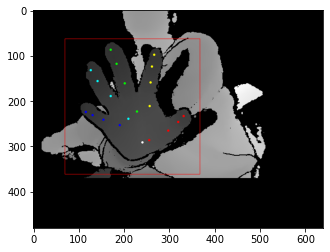

In [59]:
result_ = result.copy()
result_ = utils.math.applyTrans(result_,mat)
result_ = jointDetector.convertHand2017ToMpOrder(result_)
display_img = utils.display.matToImg(depth_img)
display_img = utils.display.drawResult(result_,display_img)
display_img = cv2.rectangle(display_img,
                            (int(test_lefttop_pixel[0]),int(test_lefttop_pixel[1])), 
                            (int(test_rightbottom_pixel[0]),int(test_rightbottom_pixel[1])),
                            (255,0,0),1)
plt.imshow(display_img)

# NYU 


In [12]:
model_nyu = "./models/a2j/model/NYU.pth"
keypoints_nyu = 14
jointDetector = models.a2j.JointDetector(model_dir=model_nyu,keypointsNumber=keypoints_nyu)

In [19]:
MEAN_NYU = np.load('./models/a2j/data/nyu/nyu_mean.npy')
STD_NYU = np.load('./models/a2j/data/nyu/nyu_std.npy')
print(MEAN_NYU,STD_NYU)

-0.66877532422628 28.329582076876047


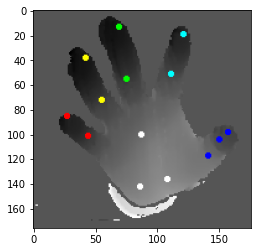

In [26]:
display_img = utils.display.matToImg(handCrop)
result = jointDetector.forward(utils.math.scaleImg(handCrop,MEAN_NYU,STD_NYU))

display_img = utils.display.drawResult(result[:,[1,0,2]],display_img,utils.colorMap.FINGER_COLORS_NYU)
plt.imshow(display_img)